<a href="https://colab.research.google.com/github/lualua0909/DeepLearning-LDS8/blob/main/Week_5/mnist_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
from tqdm import tqdm
from time import sleep

In [3]:
pbar = tqdm(total=100)
for i in range(10):
    sleep(0.1)
    pbar.update(10)
pbar.close()

100%|██████████| 100/100 [00:01<00:00, 98.16it/s]


In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten, LeakyReLU
from tensorflow.keras.layers import Convolution2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import initializers

In [9]:
random_dim=100

In [10]:
#Load MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = X_train.reshape(60000, 784)

11501568/11490434 [==============================] - 0s 0us/step


In [21]:
# viet lai duoi dang function doc du lieu
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)


In [29]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [30]:
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, 
                        input_dim=random_dim, 
                        kernel_initializer=initializers.RandomNormal(stddev=0.02))) #https://www.tensorflow.org/api_docs/python/tf/keras/initializers/RandomNormal
    generator.add(LeakyReLU(0.2)) #https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Leaky_ReLU, Leaky ReLUs allow a small, positive gradient when the unit is not active

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [31]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, 
                            input_dim=784, 
                            kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [32]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False 
    # since we only want to train either the generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,)) 
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [33]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim]) # random_dim = 100
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')        
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [34]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        # tao thanh process bar: https://tqdm.github.io/
        for _ in tqdm(range(int(batch_count))): 
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)
        # in ket qua ra file: # save_generated_images(e, generator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.16it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.24it/s]


--------------- Epoch 3 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.26it/s]


--------------- Epoch 4 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.17it/s]


--------------- Epoch 5 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.21it/s]


--------------- Epoch 6 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.20it/s]


--------------- Epoch 7 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.26it/s]


--------------- Epoch 8 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.22it/s]


--------------- Epoch 9 ---------------


100%|██████████| 468/468 [01:28<00:00,  5.29it/s]


--------------- Epoch 10 ---------------


100%|██████████| 468/468 [01:28<00:00,  5.27it/s]


--------------- Epoch 11 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.24it/s]


--------------- Epoch 12 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.25it/s]


--------------- Epoch 13 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.20it/s]


--------------- Epoch 14 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.26it/s]


--------------- Epoch 15 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.19it/s]


--------------- Epoch 16 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.24it/s]


--------------- Epoch 17 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.24it/s]


--------------- Epoch 18 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.26it/s]


--------------- Epoch 19 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.12it/s]


--------------- Epoch 20 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.19it/s]


--------------- Epoch 21 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.22it/s]


--------------- Epoch 22 ---------------


100%|██████████| 468/468 [01:28<00:00,  5.27it/s]


--------------- Epoch 23 ---------------


100%|██████████| 468/468 [01:28<00:00,  5.26it/s]


--------------- Epoch 24 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.13it/s]


--------------- Epoch 25 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.22it/s]


--------------- Epoch 26 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.17it/s]


--------------- Epoch 27 ---------------


100%|██████████| 468/468 [01:28<00:00,  5.27it/s]


--------------- Epoch 28 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.19it/s]


--------------- Epoch 29 ---------------


100%|██████████| 468/468 [01:28<00:00,  5.29it/s]


--------------- Epoch 30 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.20it/s]


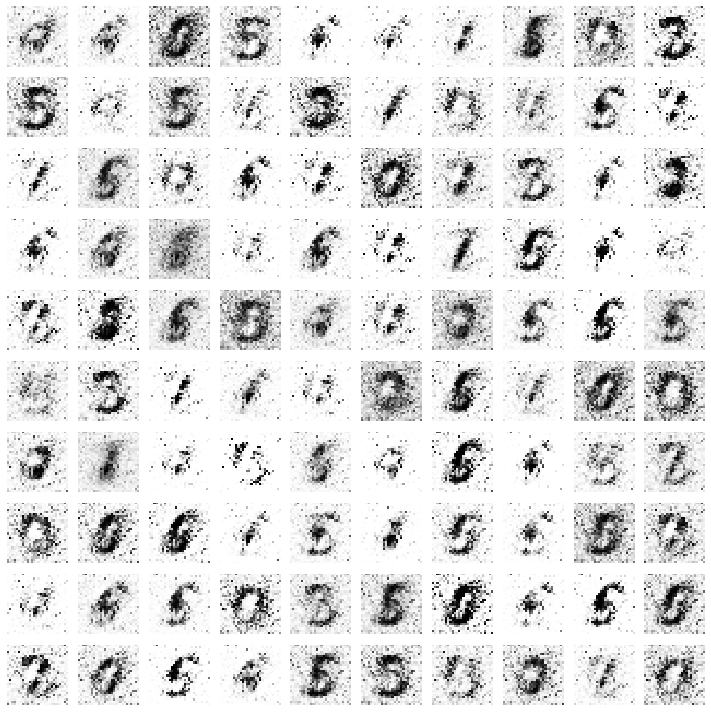

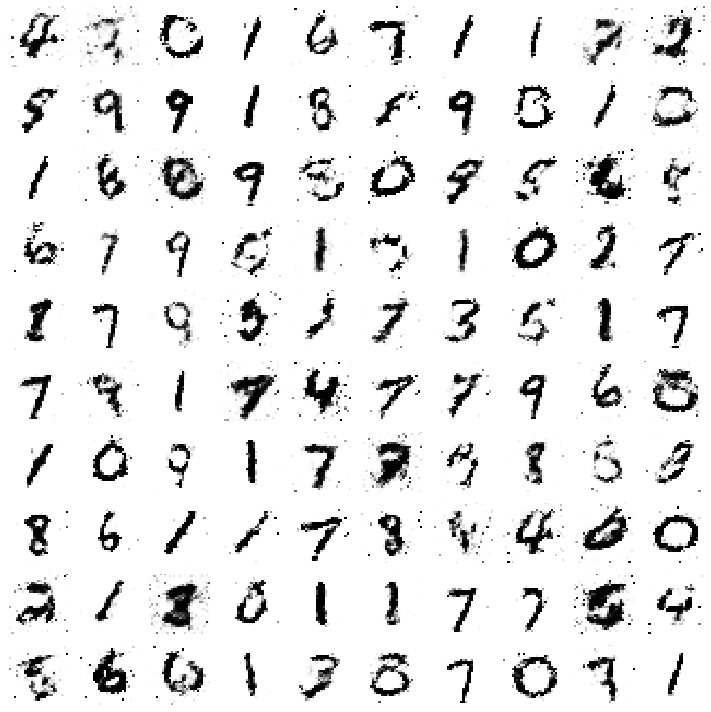

In [35]:
train(30, 128) #epoch=30, batch size = 128